# Inverting gauss map for implicity surfaces
## Vertices case

For $n\in\mathbb{R}^3$ in the sphere we obtain the inverse points in the surface 

$$ f(x,y,z) = 0$$  

as the critical points of the energy function

$$ E_f(x,y,z) = \alpha f(x,y,z)^2 + \beta |g(x,y,z)- n|^2$$

where

$$ g(x,y,z) = \nabla f(x,y,z)/|\nabla f(x,y,z)|.$$

In [1]:
using Pkg
Pkg.activate(".")
using PlotlyJS
using DelimitedFiles
using Statistics
using Flux
using Optim
using LinearAlgebra: norm, dot, cross
using Clustering: dbscan

#
# Utility functions
#
#######################

function random_points(box, n)
    xs = rand(n) .* (box[2] - box[1]) .+ box[1]
    ys = rand(n) .* (box[4] - box[3]) .+ box[3]
    zs = rand(n) .* (box[6] - box[5]) .+ box[5]
    return xs, ys, zs
end

function grid_points(box; resolution=10)
    size = resolution^3
    xs = zeros(size)
    ys = zeros(size)
    zs = zeros(size)
    i = 1
    for x in range(box[1], box[2], length=resolution)
        for y in range(box[3], box[4], length=resolution)
            for z in range(box[5], box[6], length=resolution)
                xs[i] = x
                ys[i] = y
                zs[i] = z
                i += 1
            end
        end
    end

    return xs, ys, zs
end

function cluster_points(xs, ys, zs)
    ps = [xs ys zs]'
    result = dbscan(ps, 0.05, min_neighbors=1, min_cluster_size=1)
    clusters = result.clusters
    nxs = []
    nys = []
    nzs = []
    for cluster in clusters
        ids = cluster.core_indices
        append!(nxs, mean(xs[ids]))
        append!(nys, mean(ys[ids]))
        append!(nzs, mean(zs[ids]))
    end
    nxs, nys, nzs
end


function get_energy(α, β; n = [0.0,0.0,1.0])
    function energy(x, y, z)
        energy = 0.0
        if α != 0.0
            energy += α * f(x,y,z)^2
        end
        if β != 0.0
            g = ∇f(x,y,z)
            h = g /norm(g) - n / norm(n)
            energy += β * dot(h, h)
        end
        return energy
    end
end


function evolve_points(energy, xs, ys, zs)
    n = length(xs)
    f = (p) -> energy(p[1], p[2], p[3])
    for i in 1:n
        sol = optimize(f, [xs[i], ys[i], zs[i]])
        p = sol.minimizer
        xs[i] = p[1]
        ys[i] = p[2]
        zs[i] = p[3]
    end
end

#
# Geometries
#
###############
function torusJet(R=2, r=1, ax=0.1, ay=-0.1)
    f(x, y, z) = (sqrt(x^2 + y^2) - R)^2 + (z - ax * x^2 - ay * y^2)^2 - r^2
    function ∇f(x, y, z)
        g = gradient(f, x, y, z)
        return [g[1], g[2], g[3]]
    end
    return f, ∇f
end

: 

# Loading sphere triangulation

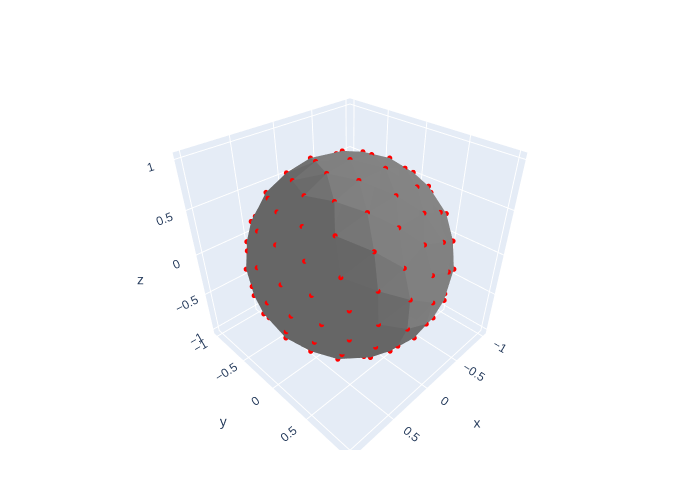

In [2]:
level = 2
vs = readdlm("../SphereTriangulation/vertices$level.txt", Float64)
ts = readdlm("../SphereTriangulation/triangles$level.txt", Int64)

sc = scatter3d(x=vs[:, 1], y=vs[:, 2], z=vs[:, 3], mode="markers", marker=attr(size=3, color="red"))
sphere_trace = GenericTrace[]
mesh = mesh3d(x=vs[:, 1], y=vs[:, 2], z=vs[:, 3], i=ts[:, 1], j=ts[:, 2], k=ts[:, 3], color="gray", opacity=1.0, flatshading=true)

push!(sphere_trace, mesh)
push!(sphere_trace, sc)
layout = Layout(width=800, height=800, scene=attr(aspectmode="data"))
plot(sphere_trace, layout)

# Finding inverse Gauss map

In [3]:
f, ∇f = torusJet()
box = [-3,3,-3,3,-1.5,1.5]
grid_x,grid_y,grid_z = grid_points(box, resolution=60)


ϵ = 0.1
surface_energy = get_energy(1.0, 0.0)
surface_cond = (surface_energy.(grid_x,grid_y,grid_z) .< ϵ^2)
surface_x = grid_x[surface_cond]
surface_y = grid_y[surface_cond]
surface_z = grid_z[surface_cond]


count = size(vs)[1]
xs_all = []
ys_all = []
zs_all = []
for i = 1:count
    n = vs[i,:]
    normal_energy = get_energy(0, 1, n =n)
    cond = (normal_energy.(surface_x,surface_y,surface_z) .< ϵ^2)
    xs = surface_x[cond]
    ys = surface_y[cond]
    zs = surface_z[cond]
    energy = get_energy(1.0, 1.0, n = n)
    evolve_points(energy, xs, ys, zs)
    xs,ys,zs = cluster_points(xs, ys, zs)
    append!(xs_all, xs)
    append!(ys_all, ys)
    append!(zs_all, zs)
end

# Plot result

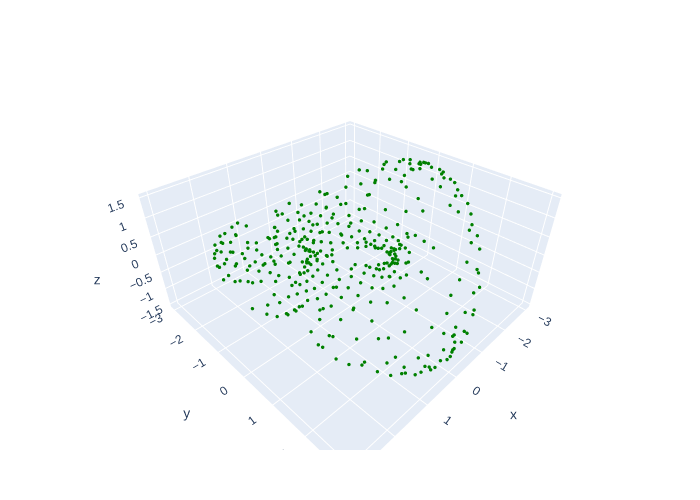

In [4]:
surface_sc = scatter3d(x=surface_x, y=surface_y, z=surface_z, mode="markers", marker=attr(size=1, color="red"))
sc = scatter3d(x=xs_all, y=ys_all, z=zs_all, mode="markers", marker=attr(size=2, color="green"))

trace = GenericTrace[]
#push!(trace, surface_sc)
push!(trace, sc)
layout = Layout(width=800, height=800, scene=attr(aspectmode="data"))
plot(trace, layout)